# ALTERNATE S4 SAMPLE CREATION - CASE B: ADD PHASE VALUES TO THE GRID OF VALUES

**NOTE:** in this notebook we use another approach to synthetic sample creation, based in the following steps:

- We start with each star in CARMENES ML subsample, taking its sampling pattern and noise characteristics.
- For each of the CARMENES stars, We create several pulsating stars, with only amplitude, frequency and phase as random input values (but from grids of values). All the rest (reference epoch and offset) are set to 0. **Note:** we restrict the possible amplitudes and frequencies to the following specific discrete values, covering all the grid of expected values for amplitude and frequency (this gives $5\times4=20$ possibilities of pulsating stars generated for each of the CARMENES star):
  - Amplitude: $A\in\;[0.1, 0.2, 0.4, 0.8, 1.6]\;m\;s^{-1}$
  - Frequency: $\nu\in\;[8.0, 16.0, 32.0, 64.0]\;d^{-1}$
  - Phase: $\delta\in\;[0.0, 0.25, 0.50, 0.75]$
- For each of the CARMENES stars, we create a number of non-pulsating synthetic stars equal to the number of created synthetic stars.

For simplicity and speed, we will only create the S4 sample (i.e., we will not generate the intermediate S1, S2 and S3 samples).

Now, there is no need to establish the precision of the values, as we will be taking specific, discrete values for amplitude and frequency.

Hence, in this case the basic equation to generate the samples is:

$$x(t)=A\cos{2\pi\nu\times t}$$

Notice that only single pulsations are modeled for each record, i.e. only a single, fundamental tone is assumed for each record.

The samples to be created are the following ones:
- Sample S4: stars created from each of the samples in CARMENES, which provides the sampling pattern and error values to the S4 stars. For the amplitude and frequency, discrete values are generated. 

## Modules and configuration

### Modules

In [43]:
import math
import pandas as pd
import numpy as np

from IPython.display import clear_output

import json

from distfit import distfit

from scipy.stats import norm

from statistics import mean, median, stdev

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [44]:
# CONFIGURATION:
MODE = "NEW" # 'NEW' to overwrite the existing datasets / 'APPEND' to add records to the datasets
AMPLITUDES = [0.1, 0.2, 0.4, 0.8, 1.6]
FREQUENCIES = [8.0, 16.0, 32.0, 64.0]
PHASES = [0.00, 0.25, 0.50, 0.75]

#N = 50 # Number of records (i.e. RV curves) to create / add. ##### NO LONGER APPLICABLE
RANDOM_STATE = 11 # For reproducibility
np.random.seed(RANDOM_STATE) # For reproducibility

#NON_PULSATION_FRACTION = 0.13 # Fraction of non-pulsating stars, a prior calculated from the fraction
#    # of stars outside the He-3 burning instability strip. ##### NO LONGER APPLICABLE

IMAGE_FOLDER = "./img/"

#DIST_SUMMARY_FILE = "../data/DIST_FILES/Parameter_distributions_ML_subsample.csv"
DIST_FILES_FOLDER = "../data/DIST_FILES/"
RV_PATTERNS_FILE = "../data/DIST_FILES/RV_ML_subsample_sampling_patterns_and_noise.csv"

DATASETS_FOLDER = "../data/SYNTH_RV_SAMPLES/"
DATASETS_SUMMARY_FILE = "../data/SYNTH_RV_SAMPLES/RV_ALTERNATIVE_S4B_Sample.csv"
#DS1_FOLDER = "../data/SYNTH_RV_SAMPLES/S1_LP_ts_files/"
#DS2_FOLDER = "../data/SYNTH_RV_SAMPLES/S2_LP_ts_files/"
#DS3_FOLDER = "../data/SYNTH_RV_SAMPLES/S3_LP_ts_files/"
S4_FOLDER = "../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_files/"

STAR_PREFIX="ALT-B_Star-" # RECOMMENDED - DO NOT CHANGE

#NEGLIGIBLE_NOISE = 1e-6 # Used to set some noise column value for the "perfect" RV curve (S1 and S3 samples)

# ROUNDING DECIMALS:
AMPLITUDE_DECIMALS = 2
FREQUENCY_DECIMALS = 2
TAU_DECIMALS = 4
DELTA_DECIMALS = 2
OFFSET_DECIMALS = 2 # (NO EFFECT FOR NZP-CORRECTED RV CURVES WITH OFFSET = 0.00)


### Functions

In [45]:
def limit_value(x, low, high):
    x_limited = np.round(x, AMPLITUDE_DECIMALS)
    if x < low:
        x_limited = np.round(low, AMPLITUDE_DECIMALS)
    if x > high:
        x_limited = np.round(high, AMPLITUDE_DECIMALS)
    return x_limited

In [46]:
def generate_errors(dist, min_value, max_value, size):
    '''Generate random values from a fitted distribution passed as parameter, but limiting
    them to the range between "min_value" and "max_value".'''
    error_values = np.round(error_dist.generate(n=size, verbose=0), AMPLITUDE_DECIMALS)
    limited_error_values = []
    limited_error_values = [limit_value(x=value,
                                        low=np.round(min_value, AMPLITUDE_DECIMALS),
                                        high=np.round(max_value, AMPLITUDE_DECIMALS)) for value in error_values]
    return limited_error_values

In [47]:
def real_value(t, f, A, c, tau, delta):
    '''Returns the value of a benchmark sample at a time 't', depending on the values of the parameters passed:
    f: frequency; A: amplitude; c: offset; tau: reference epoch; delta: phase; error: error margin'''
    # First generate the real value:
    real_value = np.round(A * np.cos(2 * np.pi * (f * (t - tau) + delta)) + c, AMPLITUDE_DECIMALS)
    return real_value

In [48]:
def observed_value(real_value, error):
    '''Generates a random observed value, given the real value and the error passed as parameters'''
    if error == 0:
        obs_value = np.round(real_value,AMPLITUDE_DECIMALS)
    else:
        norm_dist = norm(loc=real_value, scale=error) ##### <TBC> PENDIENTE DE CONFIRMAR QUE SEA ERROR=1-SIGMA
        obs_value = np.round(norm_dist.rvs(size=1), AMPLITUDE_DECIMALS)
    return obs_value    

In [49]:
np.pi

3.141592653589793

In [50]:
# We vectorize the previous functions to be able to pass arrays as parameters,
# in order to calculate the time series in one call
v_real_value = np.vectorize(real_value)
v_observed_value = np.vectorize(observed_value)

## Prepare distributions of parameters

## Create the random samples and the RV curve files

In [51]:
# TEST 1 - Vectorized function: clean time series.
test_real = v_real_value(t=[0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, \
                            6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00, 10.50, 11.00, 11.50],
                         f=0.75, A=5.0, c=20.0, tau=0.5, delta=0.2)
test_real

array([22.27, 21.55, 15.54, 24.76, 17.73, 18.45, 24.46, 15.24, 22.27,
       21.55, 15.54, 24.76, 17.73, 18.45, 24.46, 15.24, 22.27, 21.55,
       15.54, 24.76, 17.73, 18.45, 24.46, 15.24])

In [52]:
# TEST 2 - Vectorized function: noisy time series.
test_obs = v_observed_value(real_value=test_real,
                            error=[1.500668159, 1.379844309, 0.578035218, 0.798004417, 1.543720686, \
                                   1.188904223, 0.161336742, 0.102133465, 1.1281597, 0.933947801, \
                                   0.431082827, 0.865645144, 1.968325011, 0.070059952, 1.342700752, \
                                   0.102406912, 1.605073208, 0.089842491, 1.993361815, 0.190272377, \
                                   0.061971617, 1.836111736, 1.201716785, 0.221183952])
test_obs

array([21.84, 20.88, 14.01, 24.75, 17.24, 17.81, 24.51, 15.28, 21.07,
       20.72, 15.33, 25.36, 18.83, 18.36, 22.96, 15.32, 24.8 , 21.55,
       14.18, 24.97, 17.71, 19.78, 26.32, 15.38])

### Initialize samples table

We first generate the grid of amplitude and frequency values:

In [53]:
af_grid = []
for f in FREQUENCIES:
    for a in AMPLITUDES:
        for p in PHASES:
            af_grid.append({'Frequency': f, 'Amplitude': a, 'Phase': p})
af_grid

[{'Frequency': 8.0, 'Amplitude': 0.1, 'Phase': 0.0},
 {'Frequency': 8.0, 'Amplitude': 0.1, 'Phase': 0.25},
 {'Frequency': 8.0, 'Amplitude': 0.1, 'Phase': 0.5},
 {'Frequency': 8.0, 'Amplitude': 0.1, 'Phase': 0.75},
 {'Frequency': 8.0, 'Amplitude': 0.2, 'Phase': 0.0},
 {'Frequency': 8.0, 'Amplitude': 0.2, 'Phase': 0.25},
 {'Frequency': 8.0, 'Amplitude': 0.2, 'Phase': 0.5},
 {'Frequency': 8.0, 'Amplitude': 0.2, 'Phase': 0.75},
 {'Frequency': 8.0, 'Amplitude': 0.4, 'Phase': 0.0},
 {'Frequency': 8.0, 'Amplitude': 0.4, 'Phase': 0.25},
 {'Frequency': 8.0, 'Amplitude': 0.4, 'Phase': 0.5},
 {'Frequency': 8.0, 'Amplitude': 0.4, 'Phase': 0.75},
 {'Frequency': 8.0, 'Amplitude': 0.8, 'Phase': 0.0},
 {'Frequency': 8.0, 'Amplitude': 0.8, 'Phase': 0.25},
 {'Frequency': 8.0, 'Amplitude': 0.8, 'Phase': 0.5},
 {'Frequency': 8.0, 'Amplitude': 0.8, 'Phase': 0.75},
 {'Frequency': 8.0, 'Amplitude': 1.6, 'Phase': 0.0},
 {'Frequency': 8.0, 'Amplitude': 1.6, 'Phase': 0.25},
 {'Frequency': 8.0, 'Amplitude': 1.6,

### Create the samples of time series in each dataset

In [54]:
# Read the sampling patterns from the RV patterns file:
rv_patterns = pd.read_csv(RV_PATTERNS_FILE)
rv_patterns['RV_sampling_deltas'] = rv_patterns['RV_sampling_deltas'] \
    .map(lambda x: json.loads(x))
rv_patterns

,Karmn,Vr_kms-1,n_RV,Ps_RV,wrms_RV,RV_sampling_deltas,RV_noise_min,RV_noise_max,RV_noise_median,RV_noise_mean,RV_noise_stdev,RV_noise_dist,RV_noise_name,RV_noise_loc,RV_noise_scale,RV_noise_dist_file,RV_noise_fit_p-value,Fraction_Out,Occurrences
0,J23505-095,-21.870867,71.0,2.908164,3.362607,"[0.0, 11.957513123750687, 47.87879143701866, 5...",1.199479,4.170413,1.722917,1.881812,0.628702,{'distr': <scipy.stats._continuous_distns.t_ge...,t,1.691561,2.901930e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,1.037264e-01,0.112676,25
1,J23492+024,-71.131000,373.0,1.143762,2.183867,"[0.0, 17.0164248123765, 190.38824744801968, 21...",0.951985,7.585994,1.517377,1.656111,0.599510,{'distr': <scipy.stats._continuous_distns.logn...,lognorm,0.862271,6.601781e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,4.903836e-01,0.000000,32
2,J23431+365,-2.597000,23.0,17.057200,2.795865,"[0.0, 8.942367421463132, 9.875712749548256, 25...",0.916620,2.010952,1.377055,1.408319,0.262370,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.403768,2.331912e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,6.875666e-01,0.043478,43
3,J23419+441,-77.764000,99.0,3.031857,2.532704,"[0.0, 136.37014811998233, 154.37618444254622, ...",0.829277,2.496016,1.297172,1.363447,0.307447,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.223698,2.125946e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,7.332463e-01,0.000000,74
4,J23381-162,20.470749,56.0,3.019729,2.405056,"[0.0, 10.978803387377411, 30.955036497674882, ...",1.016080,3.446221,1.423674,1.611703,0.542434,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.343269,2.486426e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,4.821267e-01,0.017857,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,J00184+440,10.997000,193.0,0.985929,2.311629,"[0.0, 13.990557200275362, 18.001077729277313, ...",0.832274,3.104075,1.331101,1.535932,0.554882,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.240303,3.236921e-01,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,1.229232e-07,0.124352,43
229,J00183+440,11.820000,216.0,0.826708,2.617721,"[0.0, 1.0492656417191029, 2.022110936231911, 3...",0.766382,4.264498,1.476962,1.556480,0.527647,{'distr': <scipy.stats._continuous_distns.beta...,beta,0.744054,7.930984e+00,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,1.844235e-01,0.000000,32
230,J00162+198E,-1.625194,18.0,42.940403,2.861697,"[0.0, 15.97568494733423, 18.95287090772763, 18...",1.102225,2.145801,1.483359,1.577230,0.338830,{'distr': <scipy.stats._continuous_distns.beta...,beta,1.102225,1.076078e+00,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,2.013803e-01,0.000000,32
231,J00067-075,-40.123002,89.0,2.510671,2.440083,"[0.0, 0.9991974416188896, 11.033571805804968, ...",1.113746,5.291221,1.482946,1.572339,0.508195,{'distr': <scipy.stats._continuous_distns.beta...,beta,1.090486,1.438121e+12,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,8.544017e-01,0.000000,32


In [55]:
print(list(rv_patterns.columns))

['Karmn', 'Vr_kms-1', 'n_RV', 'Ps_RV', 'wrms_RV', 'RV_sampling_deltas', 'RV_noise_min', 'RV_noise_max', 'RV_noise_median', 'RV_noise_mean', 'RV_noise_stdev', 'RV_noise_dist', 'RV_noise_name', 'RV_noise_loc', 'RV_noise_scale', 'RV_noise_dist_file', 'RV_noise_fit_p-value', 'Fraction_Out', 'Occurrences']


In [57]:
# NOTE: THIS IS HIGHLY INNEFECTIVE, THE USE OF "loc" INSIDE A LOOP
# BETTER SOLUTION WOULD BE TO CREATE LISTS OF VALUES AND THEN CREATE THE DATAFRAME AT THE END.
# Check the proper column names in the patterns file:
# Initialize lists of values to be filled up:
id_list = []
starclass_list = []
frequency_list = []
amplitude_list = []
offset_list = []
refepoch_list = []
phase_list = []
carmidx_list = []
carmref_list = []
errorloc_list = []
errorscale_list = []
errormean_list = []
errormedian_list = []
errorstdev_list = []
tobs_list = []
psmean_list = []
psmedian_list = []
psstdev_list = []
numpts_list = []
s4file_list = []

star_id = 0 # Synthetic star identifier.
#for idx in range(0, 1): # TEST
#for idx in range(0, 3): # TEST
for idx in range(0, len(rv_patterns)):
    clear_output(wait=True)
    if True: # TEST
    #try:
        step = "CARMENES RV curve parameters"
        karmn_id = rv_patterns.loc[idx, 'Karmn']
        print("PROCESSING CARMENES RECORD %d OF %d..." %(idx, len(rv_patterns)))
        print("Generating synthetic stars from CARMENES star %s" %karmn_id)
        # Retrieve the CARMENES RV curve parameters:
        num_points = rv_patterns.loc[idx, 'n_RV']
        rv_t_deltas = rv_patterns.loc[idx, 'RV_sampling_deltas']
        error_dist = distfit()
        error_dist.load(rv_patterns.loc[idx, 'RV_noise_dist_file'])
        error_min = rv_patterns.loc[idx, 'RV_noise_min']
        error_max = rv_patterns.loc[idx, 'RV_noise_max']
        for j in range(0, len(af_grid)):
            for star_class in ['Pulsating', 'Non-Pulsating']:
                # Set the record sequential ID and the pulsation characteristic:
                record_id = STAR_PREFIX + str(star_id).zfill(5)
                print("Generating synthetic star %s (%s)..." %(record_id, star_class))
                if star_class == 'Pulsating':
                    print("Generating" )
                    # Generate the pulsating star:
                    frequency = af_grid[j]['Frequency']
                    amplitudeRV = af_grid[j]['Amplitude']
                    phase = af_grid[j]['Phase']
                    offsetRV = 0.0
                    refepoch = 0.0
                    # S4 sample file creation for pulsating star:
                    
                else:
                    # Generate the non-pulsating star
                    frequency = 0.0
                    amplitudeRV = 0.0
                    phase = 0.0
                    offsetRV = 0.0
                    refepochRV = 0.0
                    # S4 sample file creation for non-pulsating star
                
                # S4: Generate the noisy and imperfectly sampled time series:
                step = "S4 calculation"
                # Generate the time axis:
                s4_time = [refepoch + t for t in rv_t_deltas]
                s4_Tobs = max(s4_time) - min(s4_time)
                s4_deltas = [a - b for a, b in zip(s4_time[1:], s4_time[:-1])]
                s4_PsRV_mean = mean(s4_deltas)
                s4_PsRV_median = median(s4_deltas)
                s4_PsRV_stdev = stdev(s4_deltas)
                
                # Generate the ideal values (sinusoidal formulas):
                s4_value = v_real_value(t=s4_time,f=frequency, A=amplitudeRV,
                                        c=offsetRV, tau=refepoch, delta=phase)
                # Error generation:
                s4_error = generate_errors(dist=error_dist,
                                            min_value=error_min, max_value=error_max,
                                            size=len(s4_time))
                s4_error = np.array(s4_error).reshape(-1,)
                # Generate the values affected by noise:
                s4_value = v_observed_value(s4_value, s4_error)
                # Generate the time series structure.
                s4_ts = np.stack([s4_time, s4_value, s4_error], axis=1).reshape(-1,3)
                # Calculate the noise stats:
                s4_error_mean = np.nanmean(s4_error.flatten())
                s4_error_median = np.nanmedian(s4_error.flatten())
                s4_error_std = np.nanstd(s4_error.flatten())
                # Create the S4 filename:
                s4_file = S4_FOLDER + "RV_" + record_id + ".dat"
                # Store the S4 file:
                np.savetxt(s4_file, s4_ts, delimiter=' ')
                
                # Append all the necessary values to the lists.
                id_list.append(record_id)
                starclass_list.append(True if star_class == 'Pulsating' else False)
                frequency_list.append(frequency)
                amplitude_list.append(amplitudeRV)
                offset_list.append(offsetRV)
                refepoch_list.append(refepoch)
                phase_list.append(phase)
                carmidx_list.append(idx)
                carmref_list.append(karmn_id)
                errorloc_list.append(rv_patterns.loc[idx, 'RV_noise_loc'])
                errorscale_list.append(rv_patterns.loc[idx, 'RV_noise_scale'])
                errormean_list.append(s4_error_mean)
                errormedian_list.append(s4_error_median)
                errorstdev_list.append(s4_error_std)
                tobs_list.append(s4_Tobs)
                psmean_list.append(s4_PsRV_mean)
                psmedian_list.append(s4_PsRV_median)
                psstdev_list.append(s4_PsRV_stdev)
                numpts_list.append(num_points)
                s4file_list.append(s4_file)

                # Update the synthetic star ID to the next one.
                star_id += 1 
    
    else: # TEST
    #except Exception as e:
        # Report any possible trouble:
        print("***ERROR: some error happened when generating record %d, at step '%s' Error: %s" \
              %(i, step, str(e)))



 

PROCESSING CARMENES RECORD 232 OF 233...
Generating synthetic stars from CARMENES star J00051+457
[pypickle] Pickle file loaded: [../data/DIST_FILES/RV_ML_subsample_Stars_noise_dist/J00051+457_RV_noise.pickle]
Generating synthetic star ALT-B_Star-37120 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37121 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37122 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37123 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37124 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37125 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37126 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37127 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37128 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37129 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37130 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37131 (Non-Pulsating)...
Gene

Generating synthetic star ALT-B_Star-37246 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37247 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37248 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37249 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37250 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37251 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37252 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37253 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37254 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37255 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37256 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37257 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37258 (Pulsating)...
Generating
Generating synthetic star ALT-B_Star-37259 (Non-Pulsating)...
Generating synthetic star ALT-B_Star-37260 (Pulsating)...
Generating
Generating syn

In [58]:
# Create the dataframe:
#list(zip(lst, lst2)
data = list(zip(id_list, starclass_list,
        frequency_list, amplitude_list, offset_list, refepoch_list, phase_list,
        carmidx_list, carmref_list,
        errorloc_list, errorscale_list, errormean_list, errormedian_list, errorstdev_list,
        tobs_list, psmean_list, psmedian_list, psstdev_list, numpts_list,
        s4file_list))
datasets = pd.DataFrame(
    data=data,
    columns=['ID', 'Pulsating', \
             'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', \
             'CARMENES_source_idx', 'CARMENES_Ref_star',
             'errorRV_dist_loc', 'errorRV_dist_scale', 'errorRV_mean', 'errorRV_median', 'errorRV_stdev', \
             'Tobs', 'Ps_mean', 'Ps_median', 'Ps_stdev', 'NumPoints', \
             'S4_ALT_file'])
# Store the dataset table so far:
datasets.to_csv(DATASETS_SUMMARY_FILE, sep=',', decimal='.', index=False)
datasets

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,CARMENES_source_idx,CARMENES_Ref_star,errorRV_dist_loc,errorRV_dist_scale,errorRV_mean,errorRV_median,errorRV_stdev,Tobs,Ps_mean,Ps_median,Ps_stdev,NumPoints,S4_ALT_file
0,ALT-B_Star-00000,True,8.0,0.1,0.0,0.0,0.00,0,J23505-095,1.691561,0.290193,1.816338,1.740,0.496892,1581.691279,22.59559,2.908164,69.264784,71.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
1,ALT-B_Star-00001,False,0.0,0.0,0.0,0.0,0.00,0,J23505-095,1.691561,0.290193,1.762535,1.720,0.456927,1581.691279,22.59559,2.908164,69.264784,71.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
2,ALT-B_Star-00002,True,8.0,0.1,0.0,0.0,0.25,0,J23505-095,1.691561,0.290193,1.802535,1.690,0.553292,1581.691279,22.59559,2.908164,69.264784,71.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
3,ALT-B_Star-00003,False,0.0,0.0,0.0,0.0,0.00,0,J23505-095,1.691561,0.290193,1.631268,1.560,0.329254,1581.691279,22.59559,2.908164,69.264784,71.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
4,ALT-B_Star-00004,True,8.0,0.1,0.0,0.0,0.50,0,J23505-095,1.691561,0.290193,1.750704,1.730,0.380797,1581.691279,22.59559,2.908164,69.264784,71.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37275,ALT-B_Star-37275,False,0.0,0.0,0.0,0.0,0.00,232,J00051+457,0.907302,0.727212,1.849423,1.680,0.593589,693.216479,13.59248,3.024201,35.635775,52.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
37276,ALT-B_Star-37276,True,64.0,1.6,0.0,0.0,0.50,232,J00051+457,0.907302,0.727212,1.660769,1.530,0.478916,693.216479,13.59248,3.024201,35.635775,52.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
37277,ALT-B_Star-37277,False,0.0,0.0,0.0,0.0,0.00,232,J00051+457,0.907302,0.727212,1.863077,1.645,0.752909,693.216479,13.59248,3.024201,35.635775,52.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...
37278,ALT-B_Star-37278,True,64.0,1.6,0.0,0.0,0.75,232,J00051+457,0.907302,0.727212,1.979615,1.660,0.880542,693.216479,13.59248,3.024201,35.635775,52.0,../data/SYNTH_RV_SAMPLES/S4B_ALTERNATIVE_ts_fi...


In [59]:
print(list(datasets.columns))

['ID', 'Pulsating', 'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', 'CARMENES_source_idx', 'CARMENES_Ref_star', 'errorRV_dist_loc', 'errorRV_dist_scale', 'errorRV_mean', 'errorRV_median', 'errorRV_stdev', 'Tobs', 'Ps_mean', 'Ps_median', 'Ps_stdev', 'NumPoints', 'S4_ALT_file']


### Show the last curves generated

#### Basic parameters of the curve

In [60]:
# Basic parameters:
print("PARAMETERS OF THE CURVE:")
if datasets.loc[star_id - 1, 'Pulsating'] == True:
    print("Star type: Pulsating star")
    print("Amplitude: %f" %amplitudeRV)
    print("Frequency: %f" %frequency)
    print("Reference epoch: %f" %refepoch)
    print("Phase: %f" %phase)
    print("Offset: %f" %offsetRV)
else:
    print("Star type: Non-pulsating star")
    print("Amplitude: %f" %amplitudeRV)
    print("Frequency: %f" %frequency)
    print("Reference epoch: %f" %refepoch)
    print("Phase: %f" %phase)
    print("Offset: %f" %offsetRV)


PARAMETERS OF THE CURVE:
Star type: Non-pulsating star
Amplitude: 0.000000
Frequency: 0.000000
Reference epoch: 0.000000
Phase: 0.000000
Offset: 0.000000


#### Simplified, quick plots

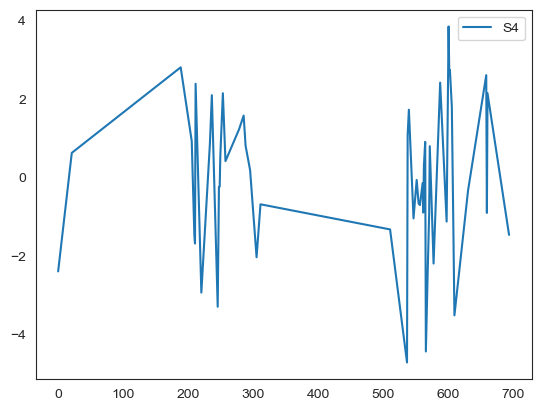

In [61]:
# S4 curves:
plt.plot(s4_time, s4_value, label='S4')
plt.legend()
plt.show();

#### More elaborated plots

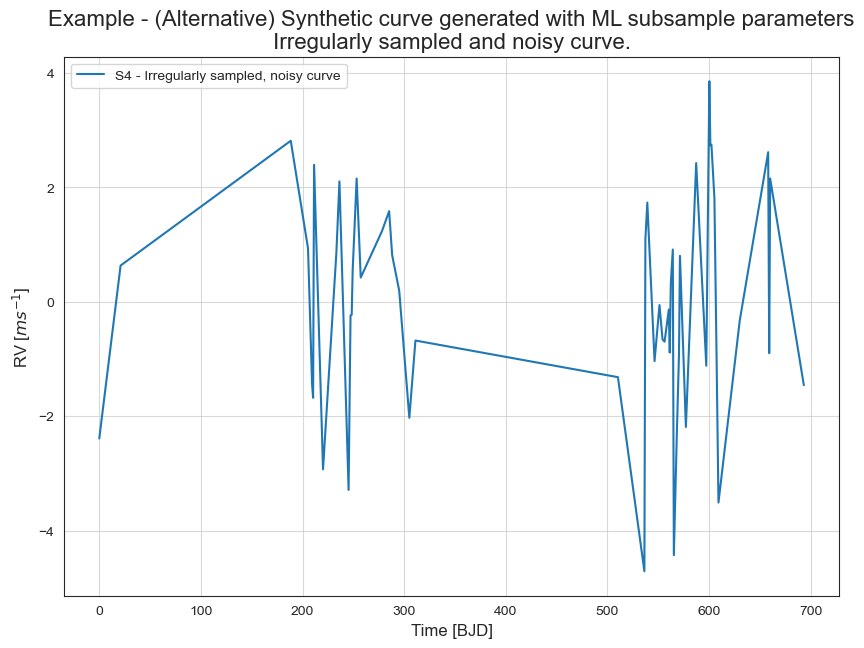

In [62]:
# S4 curves:
plt.figure(figsize=(10,7))
plt.title("Example - (Alternative) Synthetic curve generated with ML subsample parameters\n" \
          "Irregularly sampled and noisy curve.", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Time [BJD]", fontsize=12)
plt.ylabel('RV [$ms^{-1}$]', fontsize=12)
sns.lineplot(x=s4_time, y=s4_value, label='S4 - Irregularly sampled, noisy curve')
plt.savefig(IMAGE_FOLDER + "SyntheticDataset_25_01_Example_ALT_Synthetic_curve_S4_LP.jpg", format='jpg')
plt.show();